## Figures in "An upper bound for extreme temperatures over midlatitude land" by Zhang and Boos

This notebook, with accompanying files, contains all materials to reproduce the figures in the main text of the paper and should run from the beginning to the end.
In order to show all the data processing steps, we try to start from raw data as much as possible, for example:
```python
gmst = xr.open_dataset('./HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc').tas_mean
```
When we are unable to start from raw data (due to file size), we will read in a pre-generated NetCDF file, for example:
```python
h2d_obs = xr.open_dataset('./histogram2d_TX_t500_Had_AIRS_2003-2014.nc').histogram
```
Please refer to the other notebook titled "Data_processing_Zhang_Boos.ipynb" for how these intermediate netCDF files are generated.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from glob import glob 
import warnings
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# import os
# os.environ["HDF5_USE_FILE_LOCKING"]="FALSE"
# xr.set_options(display_style='text')

In [2]:
%%time
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

CPU times: user 42 µs, sys: 0 ns, total: 42 µs
Wall time: 44.1 µs


In [3]:
%%time
## Western North America (45N, 55N, 116W, 123W)
lat_slice_pn = slice(55,45)
lon_slice_pn =slice(237,244)

## Russia (50N, 57N, 35E, 45E)
lat_slice_rs = slice(57,50)
lon_slice_rs =slice(35,45)

## Western europe (45N, 53N, 3E, 13E)
lat_slice_fr = slice(53,46)
lon_slice_fr =slice(3,13)

## Time slices of three heatwaves
time_pn = slice('2021-06-26','2021-07-01')
time_fr = slice('2019-07-23','2019-07-25')
time_rs = slice('2010-07-31','2010-08-11')

# Land masks
lsm = xr.open_dataset('./e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc').LSM.squeeze()
land = lsm.where(lsm>0.5)*0+1
ocean = lsm.where(lsm<=0.5)*0+1
weights = np.cos(np.deg2rad(land.latitude))

# Physical constants
cp = 1.0047090 
L = 2.5008e3
ep = 0.621981
e = 1e-6
R = 287.058 
g = 9.81



def e_sat(t): # Clausius Clapeyron [K] [Pa]
    return 611.21*np.exp(17.502*((t-273.16)/(t-32.19)))

def alpha(t): # de_sat/dT [K] [Pa]
    return 4217.457/(t-32.19)**2# Constants followed ECMWF

def e2q(e,sp):
    return 0.621981*e/(sp-(1-0.621981)*e)

z500_mean = 55.74162890625
t500_mean = 258.82523

# Functions

def xr_linregress(x, y, dim="time"):
    # align the nan Values before...
    x = x.where(~np.isnan(y))
    y = y.where(~np.isnan(x))
    n = y.notnull().sum(dim)

    nanmask = np.isnan(y).all(dim)

    xmean = x.mean(dim)
    ymean = y.mean(dim)
    xstd = x.std(dim)
    ystd = y.std(dim)

    cov = ((x - xmean) * (y - ymean)).sum(dim) / (n)
    cor = cov / (xstd * ystd)

    slope = cov / (xstd ** 2)
    intercept = ymean - xmean * slope

    df = n - 2
    TINY = 1.0e-20
    tstats = cor * np.sqrt(df / ((1.0 - cor + TINY) * (1.0 + cor + TINY)))
    stderr = slope / tstats

    pval = (
        xr.apply_ufunc(
            sts.distributions.t.sf,
            abs(tstats),
            df,
            dask="parallelized",
            output_dtypes=[y.dtype],
        )
        * 2
    )

    return xr.Dataset(
        {
            "slope": slope,
            "intercept": intercept,
            "r_value": cor.fillna(0).where(~nanmask),
            "p_value": pval,
            "std_err": stderr.where(~np.isinf(stderr), 0),
        }
    )

CPU times: user 634 ms, sys: 87.5 ms, total: 721 ms
Wall time: 815 ms


------------
### Figure 1

In [4]:
# Refer to the other notebook for how data in this block were generated 
t500_pn_anom = xr.open_dataset('./t500_anom_20210626-20210701.nc').t500
t500_fr_anom = xr.open_dataset('./t500_anom_20190723-20190725.nc').t500
t500_rs_anom = xr.open_dataset('./t500_anom_20100731-20100811.nc').t500
TX_pn_anom = xr.open_dataset('./TX_anom_20210626-20210701.nc').TX
TX_fr_anom = xr.open_dataset('./TX_anom_20190723-20190725.nc').TX
TX_rs_anom = xr.open_dataset('./TX_anom_20100731-20100811.nc').TX

In [5]:
TXx = xr.open_dataset('./TXx_1979-2021.nc').TXx # Annual hottest daily maximum temperature from ERA5 hourly data
TXx_midlat = (TXx*land).sel(latitude=slice(65,40))
TXx_midlat_clim = TXx_midlat.mean('time')
TXx_midlat_var = TXx_midlat.std('time')
TXx_midlat_anom = (TXx_midlat-TXx_midlat_clim)/TXx_midlat_var
hist, _ = np.histogram(TXx_midlat_anom, bins=np.arange(-5,5.01,0.05))
TXx_pn_anom = TXx_midlat_anom.sel(latitude=lat_slice_pn, longitude=lon_slice_pn).compute()
TXx_fr_anom = TXx_midlat_anom.sel(latitude=lat_slice_fr, longitude=lon_slice_fr).compute()
TXx_rs_anom = TXx_midlat_anom.sel(latitude=lat_slice_rs, longitude=lon_slice_rs).compute()

CPU times: user 12.8 s, sys: 260 ms, total: 13.1 s
Wall time: 13.1 s


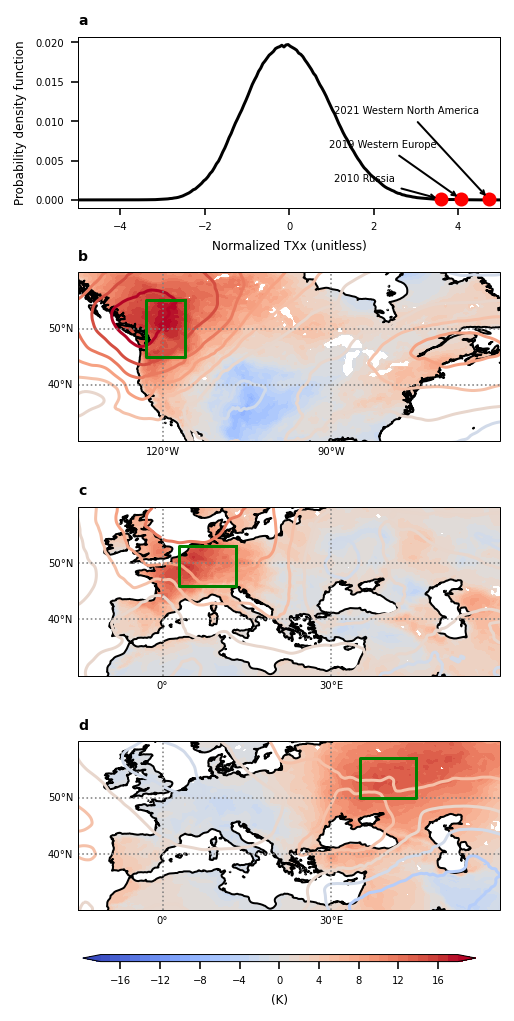

In [5]:
%%time
fig = plt.figure(figsize=(3.5, 7))
plt.subplot(411)


plt.plot(np.arange(-5,5.01,0.05)[0:-1]+0.025, hist/hist.sum(), 'k')
plt.plot(TXx_pn_anom.max(), 0.0001, 'or')
plt.annotate('2021 Western North America', xy=(TXx_pn_anom.max(), 0.0001),  xycoords='data',
            xytext=(0.95, 0.6), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',  arrowstyle="->",),
            horizontalalignment='right', verticalalignment='top',
            )


plt.plot(TXx_fr_anom.max(), 0.0001, 'or')
plt.annotate('2019 Western Europe', xy=(TXx_fr_anom.max(), 0.0001),  xycoords='data',
            xytext=(0.85, 0.4), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',  arrowstyle="->",),
            horizontalalignment='right', verticalalignment='top',
            )

plt.plot(TXx_rs_anom.max(), 0.0001, 'or')
plt.annotate('2010 Russia', xy=(TXx_rs_anom.max(), 0.0001),  xycoords='data',
            xytext=(0.75, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black',  arrowstyle="->",),
            horizontalalignment='right', verticalalignment='top',
            )

plt.xlim([-5,5])
plt.xlabel('Normalized TXx (unitless)')
plt.ylabel('Probability density function')
plt.title('a', loc='left', weight='bold')

ax = plt.subplot(412, projection=ccrs.PlateCarree())
ax.coastlines(color='k', linewidth=1)
ax.set_extent([360-135, 360-60, 30, 60], crs=ccrs.PlateCarree())
ax.plot([lon_slice_pn.stop, lon_slice_pn.start, lon_slice_pn.start, lon_slice_pn.stop,lon_slice_pn.stop], 
        [lat_slice_pn.start, lat_slice_pn.start, lat_slice_pn.stop, lat_slice_pn.stop, lat_slice_pn.start], 'g',transform=ccrs.PlateCarree())
im = ax.contourf(TX_pn_anom.longitude, TX_pn_anom.latitude, 
            TX_pn_anom*land, 
            levels=np.arange(-18,18.1,1), cmap='coolwarm', extend='both')
t500_pn_anom.plot.contour(ax=ax, levels=np.arange(-11,11.1,2), cmap='coolwarm', extend='both')
gl = ax.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180,30), 
                 ylocs=[40, 50], linestyle=':', 
                 color='gray', alpha=1, draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.title('b', loc='left', weight='bold')

ax = plt.subplot(413, projection=ccrs.PlateCarree())
ax.coastlines(color='k', linewidth=1)
ax.set_extent([-15, 60, 30, 60], crs=ccrs.PlateCarree())
ax.plot([lon_slice_fr.stop, lon_slice_fr.start, lon_slice_fr.start, lon_slice_fr.stop,lon_slice_fr.stop], 
        [lat_slice_fr.start, lat_slice_fr.start, lat_slice_fr.stop, lat_slice_fr.stop, lat_slice_fr.start], 'g',transform=ccrs.PlateCarree())
im = ax.contourf(TX_fr_anom.longitude, TX_fr_anom.latitude, 
            TX_fr_anom*land,
            levels=np.arange(-18,18.1,1), cmap='coolwarm', extend='both')
t500_fr_anom.plot.contour(ax=ax, levels=np.arange(-11,11.1,2), cmap='coolwarm',extend='both')
gl = ax.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180,30), 
                 ylocs=[40,50], linestyle=':', 
                 color='gray', alpha=1, draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.title('c', loc='left', weight='bold')

ax = plt.subplot(414, projection=ccrs.PlateCarree())
ax.coastlines(color='k', linewidth=1)
ax.set_extent([-15, 60, 30, 60], crs=ccrs.PlateCarree())
ax.plot([lon_slice_rs.stop, lon_slice_rs.start, lon_slice_rs.start, lon_slice_rs.stop,lon_slice_rs.stop], 
        [lat_slice_rs.start, lat_slice_rs.start, lat_slice_rs.stop, lat_slice_rs.stop, lat_slice_rs.start], 'g',transform=ccrs.PlateCarree())
im = ax.contourf(TX_rs_anom.longitude, TX_rs_anom.latitude, 
            TX_rs_anom*land,
            levels=np.arange(-18,18.1,1), cmap='coolwarm', extend='both')
t500_rs_anom.plot.contour(ax=ax, levels=np.arange(-11,11.1,2), cmap='coolwarm',extend='both')

gl = ax.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180,30), 
                 ylocs=[40,50], linestyle=':', 
                 color='gray', alpha=1, draw_labels=True)
gl.right_labels = False
gl.top_labels = False
plt.title('d', loc='left', weight='bold')

fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.15, 0.05, 0.78, 0.007])
plt.colorbar(mappable=im, label='(K)', cax = cbar_ax, orientation = 'horizontal')

plt.savefig('./Fig1.pdf')

---------------
### Figure 2

In [6]:
# Refer to the other notebook for how data in this block were generated 
pr_TX_lag = xr.open_dataset('./pr_TX_day_2010.nc').pr_TX
t2m_TX_lag = xr.open_dataset('./t2m_TX_hour_2010.nc').t2m_TX
h2m_TX_lag = xr.open_dataset('./h2m_TX_hour_2010.nc').h2m_TX
hsat500_TX_lag = xr.open_dataset('./hsat500_TX_hour_2010.nc').hsat500_TX
cape_TX_lag = xr.open_dataset('./cape_TX_hour_2010.nc').cape_TX

CPU times: user 31.2 ms, sys: 4.41 ms, total: 35.6 ms
Wall time: 37.8 ms


CPU times: user 2.67 s, sys: 3.96 s, total: 6.63 s
Wall time: 6.65 s


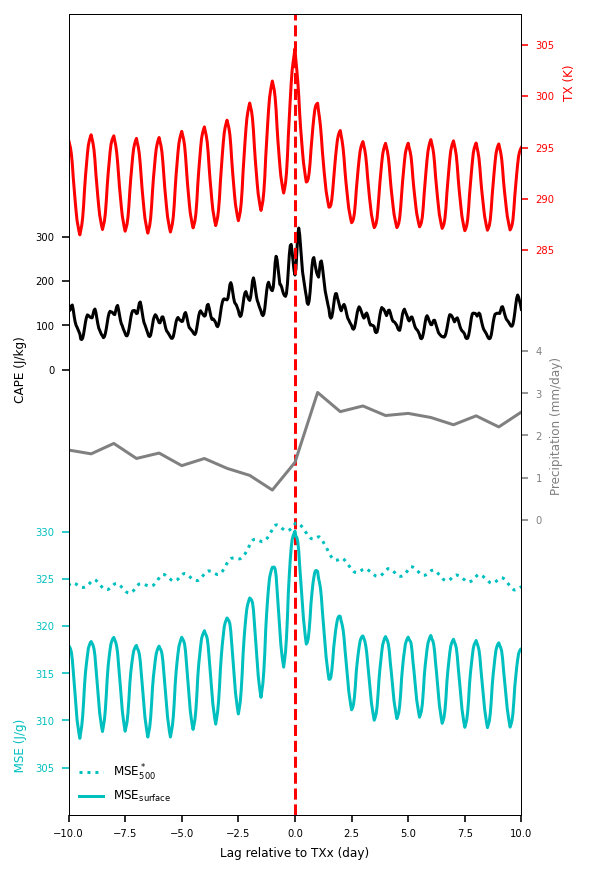

In [7]:
%%time
fig, ax = plt.subplots(figsize=(4, 6))
ax0 =ax.twinx()
ax000 = ax.twinx()
ax00 = ax000.twinx()
ax.plot(cape_TX_lag.lag, (cape_TX_lag*land).mean(['year','latitude','longitude']), label='CAPE', c='k')
ax00.plot(pr_TX_lag.lag, (pr_TX_lag*land).mean(['year','latitude','longitude']), label='Precipitation', c='grey')
ax0.plot(t2m_TX_lag.lag, (t2m_TX_lag*land).mean(['year','latitude','longitude']), label='TX', c='r')
ax000.plot(hsat500_TX_lag.lag, (hsat500_TX_lag*land).mean(['year','latitude','longitude']), label='MSE$^*_\mathrm{500}$', c='c', ls=':')
ax000.plot(hsat500_TX_lag.lag, (h2m_TX_lag*land).mean(['year','latitude','longitude']), label='MSE$_\mathrm{surface}$', c='c')

ax000.legend(frameon=0, loc='lower left')
ax.set_ylim([-1000,800])

ax.set_yticks(np.arange(0,400,100))
ax00.set_ylim([-7,12])
ax00.set_yticks(np.arange(0,5,1))
ax000.set_ylim([300,385])
ax000.set_yticks(np.arange(305,335,5))
ax0.set_ylim([230,308])
ax0.set_yticks(np.arange(285,310,5))
ax000.yaxis.set_label_position("left")
ax000.set_ylabel('           MSE (J/g)', c='c', loc='bottom')
ax.set_ylabel('                       CAPE (J/kg)')
ax0.set_ylabel('TX (K)             ', loc='top', c='r')
ax00.set_ylabel('Precipitation (mm/day)      ', c='grey')
ax0.tick_params(axis='y', colors='r')
ax00.tick_params(axis='y', colors='grey')
ax000.tick_params(axis='y', colors='c')
ax.set_xlim([-10,10])
ax.axvline(x=0, ls='--', c='r')
ax.set_xlabel('Lag relative to TXx (day)')
fig.tight_layout()
fig.savefig('./Fig2.pdf')

---------------
### Figure 3

In [8]:
# Refer to the other notebook for how data in this block were generated 
h2d_era5 = xr.open_dataset('./histogram2d_TX_t500_1979-2021.nc').histogram
h2d_obs = xr.open_dataset('./histogram2d_TX_t500_Had_AIRS_2003-2014.nc').histogram
h2d_sm = xr.open_dataset('./histogram2dweighted_sm_TX_t500_2001-2020.nc').histogram
h2d_vo = xr.open_dataset('./histogram2dweighted_vo_TX_t500_2001-2020.nc').histogram

z500_mean =55.74162890625 # Mean 500-hPa geopotential between 40N-65N over land during 1979-2021
t500_mean = 258.82523 # Mean 500-hPa temperature between 40N-65N over land during 1979-2021

# Surface geopotential (unit: 1e3 m2/s2)
gzs_pn = 10.85631501
gzs_fr = 4.46191664
gzs_rs = 1.61871271

t500_pn = xr.open_dataset('t500_pn_1979-2021.nc').t500
t500_fr = xr.open_dataset('t500_fr_1979-2021.nc').t500
t500_rs = xr.open_dataset('t500_rs_1979-2021.nc').t500

TX_pn = xr.open_dataset('TX_pn_1979-2021.nc').TX
TX_fr = xr.open_dataset('TX_fr_1979-2021.nc').TX
TX_rs = xr.open_dataset('TX_rs_1979-2021.nc').TX

CPU times: user 50.5 ms, sys: 11.4 ms, total: 61.8 ms
Wall time: 64.4 ms


CPU times: user 15.4 s, sys: 11.7 s, total: 27.1 s
Wall time: 27.7 s


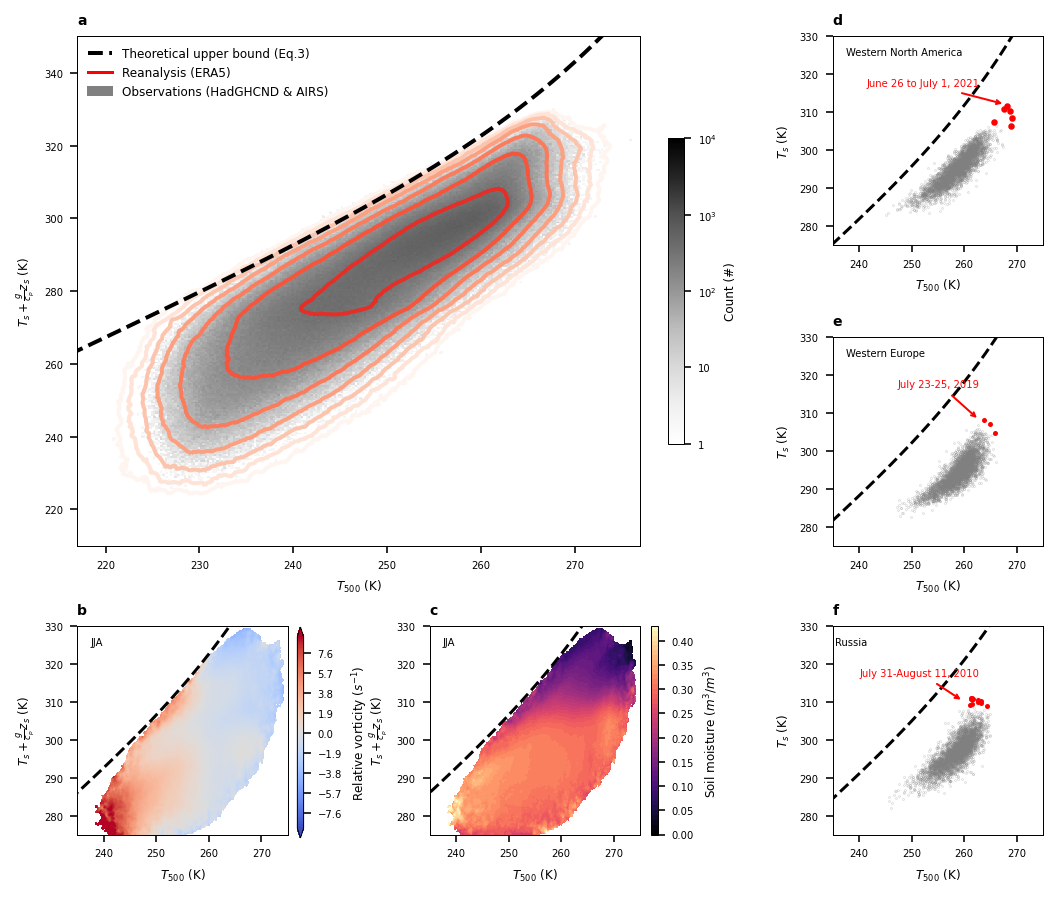

In [12]:
%%time
import matplotlib.gridspec as gridspec
 
fig = plt.figure(constrained_layout=True, figsize=(7.2,6.1))
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig, width_ratios=(1,1,1.),  height_ratios=(1,1,1.), wspace=0.12)
ax1 = fig.add_subplot(spec[0:2, 0:2])

ax1.contour(h2d_era5.x_bins, h2d_era5.y_bins, np.log10(h2d_era5.sel(time=slice('2001','2020')).sum('time')).transpose(), levels=np.arange(2,7,0.5),  cmap='Reds', linewidths=[2])
im1 = ax1.pcolor(h2d_obs.x_bins, h2d_obs.y_bins, np.log10(h2d_obs.sel(time=slice('2001','2020')).sum('time')).transpose(), vmax=4, cmap='Greys')
x = np.arange(210,280)
ax1.plot(x,1/cp*(cp*x+L*e2q(e_sat(x),50000)+z500_mean/t500_mean*x), '--k', label='Theoretical upper bound (Eq.3)', lw=2)


ax1.set_xlabel('$T_{\mathrm{500}}$ (K)')
ax1.set_ylabel(r'$T_s+\frac{g}{c_p}z_s$ (K)')
ax1.set_xlim([217,277])
ax1.set_ylim([210, 350])
ax1.fill_between([], [], color='grey', label='Observations (HadGHCND & AIRS)')
ax1.plot([], [], color='red', label='Reanalysis (ERA5)')
ax1.set_title('a', loc='left', weight='bold')
ax1.legend(frameon=0)
cbar = plt.colorbar(label='Count (#)', ticks=np.arange(0,4.1,1), mappable=im1, fraction=0.2, shrink=0.6)
cbar.ax.set_yticklabels(['1','10','$10^2$', '$10^3$','$10^4$',])

ax2 = fig.add_subplot(spec[2, 0])
data =  (h2d_vo.sum('time')/h2d_era5.sel(time=h2d_era5['time.season']=='JJA').sel(time=slice('2001','2020')).sum('time'))
data = data.where(h2d_era5.sel(time=h2d_era5['time.season']=='JJA').sel(time=slice('2001','2020')).sum('time')>50)
im2 = plt.contourf(h2d_vo.x_bins, h2d_vo.y_bins, 1e5*data.transpose(), levels=np.arange(-0.00009, 0.000091, 0.000001)*1e5, extend='both', cmap='coolwarm')
x = np.arange(210,280)
ax2.plot(x,1/cp*(cp*x+L*e2q(e_sat(x),50000)+z500_mean/t500_mean*x), '--k')
ax2.set_xlabel('$T_{\mathrm{500}}$ (K)')
ax2.set_ylabel(r'$T_s+\frac{g}{c_p}z_s$ (K)')
ax2.set_xlim([235,275])
ax2.set_ylim([275, 330])
ax2.text(237.5, 325, 'JJA')
ax2.set_title('b', loc='left', weight='bold')
# plt.colorbar(label='Relative vorticity ($s^{-1}$)', mappable=im2)
cax2 = fig.add_axes([0.275, 0.055, 0.006, 0.24])
cbar = plt.colorbar(label='Relative vorticity ($s^{-1}$)', cax=cax2, mappable=im2)


ax3 = fig.add_subplot(spec[2, 1])
data =  (h2d_sm.sum('time')/h2d_era5.sel(time=h2d_era5['time.season']=='JJA').sel(time=slice('2001','2020')).sum('time'))
data = data.where(h2d_era5.sel(time=h2d_era5['time.season']=='JJA').sel(time=slice('2001','2020')).sum('time')>50)
im3 = plt.contourf(h2d_sm.x_bins, h2d_sm.y_bins, data.transpose(), levels=np.arange(0, 0.44,0.01), cmap='magma')
x = np.arange(210,280)
ax3.plot(x,1/cp*(cp*x+L*e2q(e_sat(x),50000)+z500_mean/t500_mean*x), '--k')
ax3.set_xlabel('$T_{\mathrm{500}}$ (K)')
ax3.set_ylabel(r'$T_s+\frac{g}{c_p}z_s$ (K)')
ax3.set_xlim([235,275])
ax3.set_ylim([275, 330])
ax3.text(237.5, 325, 'JJA')
ax3.set_title('c', loc='left', weight='bold')
plt.colorbar(label='Soil moisture ($m^3/m^3$)',mappable=im3, aspect=30, orientation='vertical')


ax4 = fig.add_subplot(spec[0, 2])
ax4.plot(t500_pn.sel(time=TX_pn['time.season']=='JJA'), TX_pn.sel(time=TX_pn['time.season']=='JJA'), '.', ms=0.2, color='grey', ls='none')
ax4.plot(t500_pn.sel(time=time_pn), TX_pn.sel(time=time_pn), 'o', ms=1.5, color='r', mfc='r')
ax4.scatter(t500_pn.sel(time=time_pn), TX_pn.sel(time=time_pn), s=5, color='r')
ax4.annotate('June 26 to July 1, 2021', xy=(268,312),  xycoords='data', color='r',
            xytext=(0.7, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='red',  arrowstyle="->", color='r'),
            horizontalalignment='right', verticalalignment='top',
            )
ax4.text(237.5, 325, 'Western North America', )
x = np.arange(210,277)
ax4.plot(x,1/cp*(cp*x+L*e2q(e_sat(x),50000)+z500_mean/t500_mean*x)-gzs_pn/cp, '--k')
ax4.set_xlabel('$T_{\mathrm{500}}$ (K)')
ax4.set_ylabel(r'$T_s$ (K)')
ax4.set_xlim([235,275])
ax4.set_ylim([275, 330])
ax4.set_title('d', loc='left', weight='bold')


ax5 = fig.add_subplot(spec[1, 2])
ax5.plot(t500_fr.sel(time=TX_fr['time.season']=='JJA'), TX_fr.sel(time=TX_fr['time.season']=='JJA'), '.', ms=0.2, color='grey', ls='none')
ax5.plot(t500_fr.sel(time=time_fr), TX_fr.sel(time=time_fr), 'o', ms=1.5, color='r', mfc='r')
ax5.annotate('July 23-25, 2019', xy=(263,308),  xycoords='data', color='r',
            xytext=(0.7, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='red',  arrowstyle="->", color='r'),
            horizontalalignment='right', verticalalignment='top',
            )
ax5.text(237.5, 325, 'Western Europe', )
x = np.arange(210,277)
ax5.plot(x,1/cp*(cp*x+L*e2q(e_sat(x),50000)+z500_mean/t500_mean*x)-gzs_fr/cp, '--k')
ax5.set_xlabel('$T_{\mathrm{500}}$ (K)')
ax5.set_ylabel(r'$T_s$ (K)')
ax5.set_xlim([235,275])
ax5.set_ylim([275, 330])
ax5.set_title('e', loc='left', weight='bold')

ax6 = fig.add_subplot(spec[2, 2])
ax6.plot(t500_rs.sel(time=TX_rs['time.season']=='JJA'), TX_rs.sel(time=TX_rs['time.season']=='JJA'), '.', ms=0.2, color='grey', ls='none')
ax6.plot(t500_rs.sel(time=time_rs), TX_rs.sel(time=time_rs), 'o', ms=1.5, color='r', mfc='r')
ax6.annotate('July 31-August 11, 2010', xy=(260,310),  xycoords='data', color='r',
            xytext=(0.7, 0.8), textcoords='axes fraction',
            arrowprops=dict(facecolor='red',  arrowstyle="->", color='r'),
            horizontalalignment='right', verticalalignment='top',
            )
ax6.text(235.5, 325, 'Russia', )
x = np.arange(210,277)
ax6.plot(x,1/cp*(cp*x+L*e2q(e_sat(x),50000)+z500_mean/t500_mean*x)-gzs_rs/cp, '--k')
ax6.set_xlabel('$T_{\mathrm{500}}$ (K)')
ax6.set_ylabel(r'$T_s$ (K)')
ax6.set_xlim([235,275])
ax6.set_ylim([275, 330])
ax6.set_title('f', loc='left', weight='bold')
plt.savefig('..Fig3.pdf')

--------------------------
### Figure 4

In [6]:
%%time
# TXx from ERA5 reanlysis
TXx = xr.open_dataset('./TXx_1979-2021.nc').TXx
TXx_mean =  (TXx*land).sel(latitude=slice(65,40)).weighted(weights).mean(['latitude','longitude'])

# T500 on the annual hottest days from ERA5 reanalysis 
t500_of_TXx = xr.open_dataset('./t500ofTXx_1979-2021.nc').t500 # Refer to the other notebook for these data were generated 
t500_of_TXx_mean = (t500_of_TXx*land).sel(latitude=slice(65,40)).weighted(weights).mean(['latitude','longitude'])
t500_trend = sts.linregress(np.arange(1979,2022), t500_of_TXx_mean).slope
t500_trend_std = sts.linregress(np.arange(1979,2022), t500_of_TXx_mean).stderr

# Calculated land-mean TXx trend from T500 trend
TXx_trend_proj = t500_trend*(1+ep*L/cp*alpha(t500_of_TXx_mean.mean())*e_sat(t500_of_TXx_mean.mean())/5e4+z500_mean/t500_mean/cp)
TXx_trend_proj_std = t500_trend_std*(1+ep*L/cp*alpha(t500_of_TXx_mean.mean())*e_sat(t500_of_TXx_mean.mean())/5e4+z500_mean/t500_mean/cp)

# GMST from HadCRUT5
gmst = xr.open_dataset('./HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc').tas_mean
gmst = gmst.assign_coords(time=pd.date_range(start='1850-01-01', end='2021-01-01', freq='AS'))

# Observed TXx from HadEX3
TXx_ex = xr.open_dataset('./HadEX3_TXx_ANN.nc').TXx.sel(time=slice('1979','2018'))
TXx_ex = TXx_ex.where(TXx_ex.count('time')>0.9*len(TXx_ex.time))  # Select grid points containing more than 90% of data during 1979-2018
weights_ex = np.cos(np.deg2rad(TXx_ex.latitude))
TXx_ex = TXx_ex.sel(latitude=slice(40,65)).weighted(weights_ex).mean(['latitude','longitude'])


# 2-D plots
time = xr.DataArray(data = np.arange(1979, 2022), coords={'time': TXx.time}, dims='time')
reg_TXx = xr_linregress(time.sel(time=slice('1979','2021')), (TXx*land).sel(time=slice('1979','2021'))).compute() # Linear trend of TXx for each location over land
factor = (1+ep*L/cp*alpha(t500_of_TXx.mean('time'))*e_sat(t500_of_TXx.mean('time'))/5e4+z500_mean/t500_mean/cp) # dTs,max/dT500 from theory for each location
reg_t500_of_TXx = xr_linregress(time.sel(time=slice('1979','2021')), (t500_of_TXx*land).sel(time=slice('1979','2021'))).compute() # T500 trend for each location over land
reg_TXx_proj = reg_t500_of_TXx*factor # Calculated TXx trend from theory and T500 trend



CPU times: user 2.41 s, sys: 1.26 s, total: 3.67 s
Wall time: 3.88 s


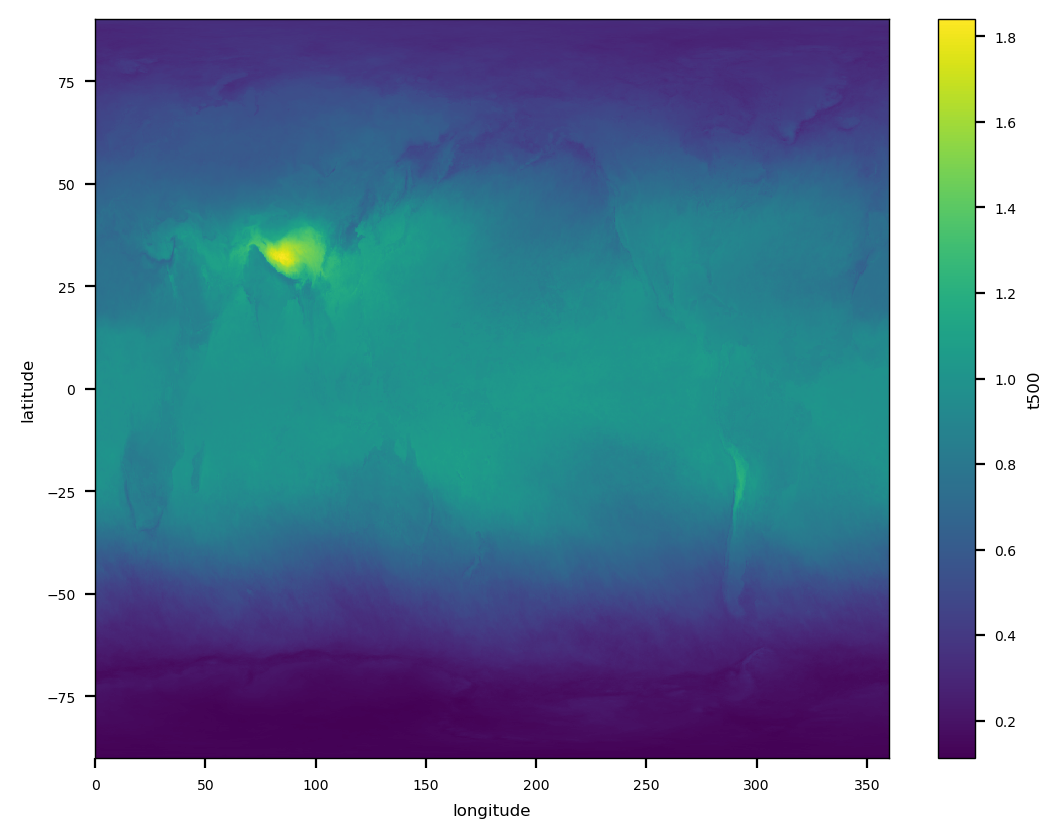

In [24]:
(ep*L/cp*alpha(t500_of_TXx.mean('time'))*e_sat(t500_of_TXx.mean('time'))/5e4).plot()

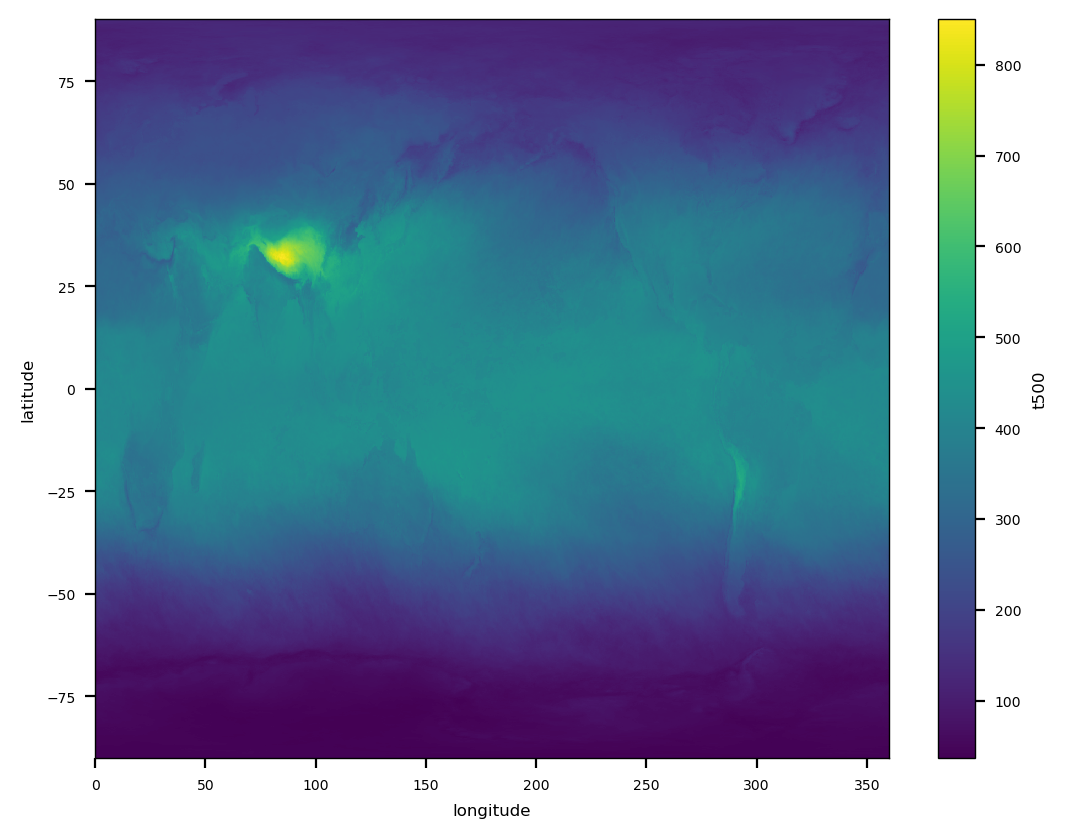

In [23]:
e_sat(t500_of_TXx.mean('time')).plot()

In [19]:
t500_of_TXx.mean('time')

<xarray.DataArray 't500' (latitude: 721, longitude: 1440)> Size: 4MB
array([[253.29831, 253.29831, 253.29831, ..., 253.29831, 253.29831,
        253.29831],
       [253.5133 , 253.51349, 253.51361, ..., 253.51294, 253.51315,
        253.51321],
       [253.39064, 253.3909 , 253.3911 , ..., 253.38994, 253.39017,
        253.39038],
       ...,
       [240.93286, 240.9329 , 240.93294, ..., 240.9713 , 240.9713 ,
        240.97134],
       [240.93922, 240.93925, 240.93925, ..., 240.93918, 240.93922,
        240.93922],
       [240.89229, 240.89229, 240.89229, ..., 240.89229, 240.89229,
        240.89229]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

CPU times: user 51 s, sys: 693 ms, total: 51.7 s
Wall time: 52.4 s


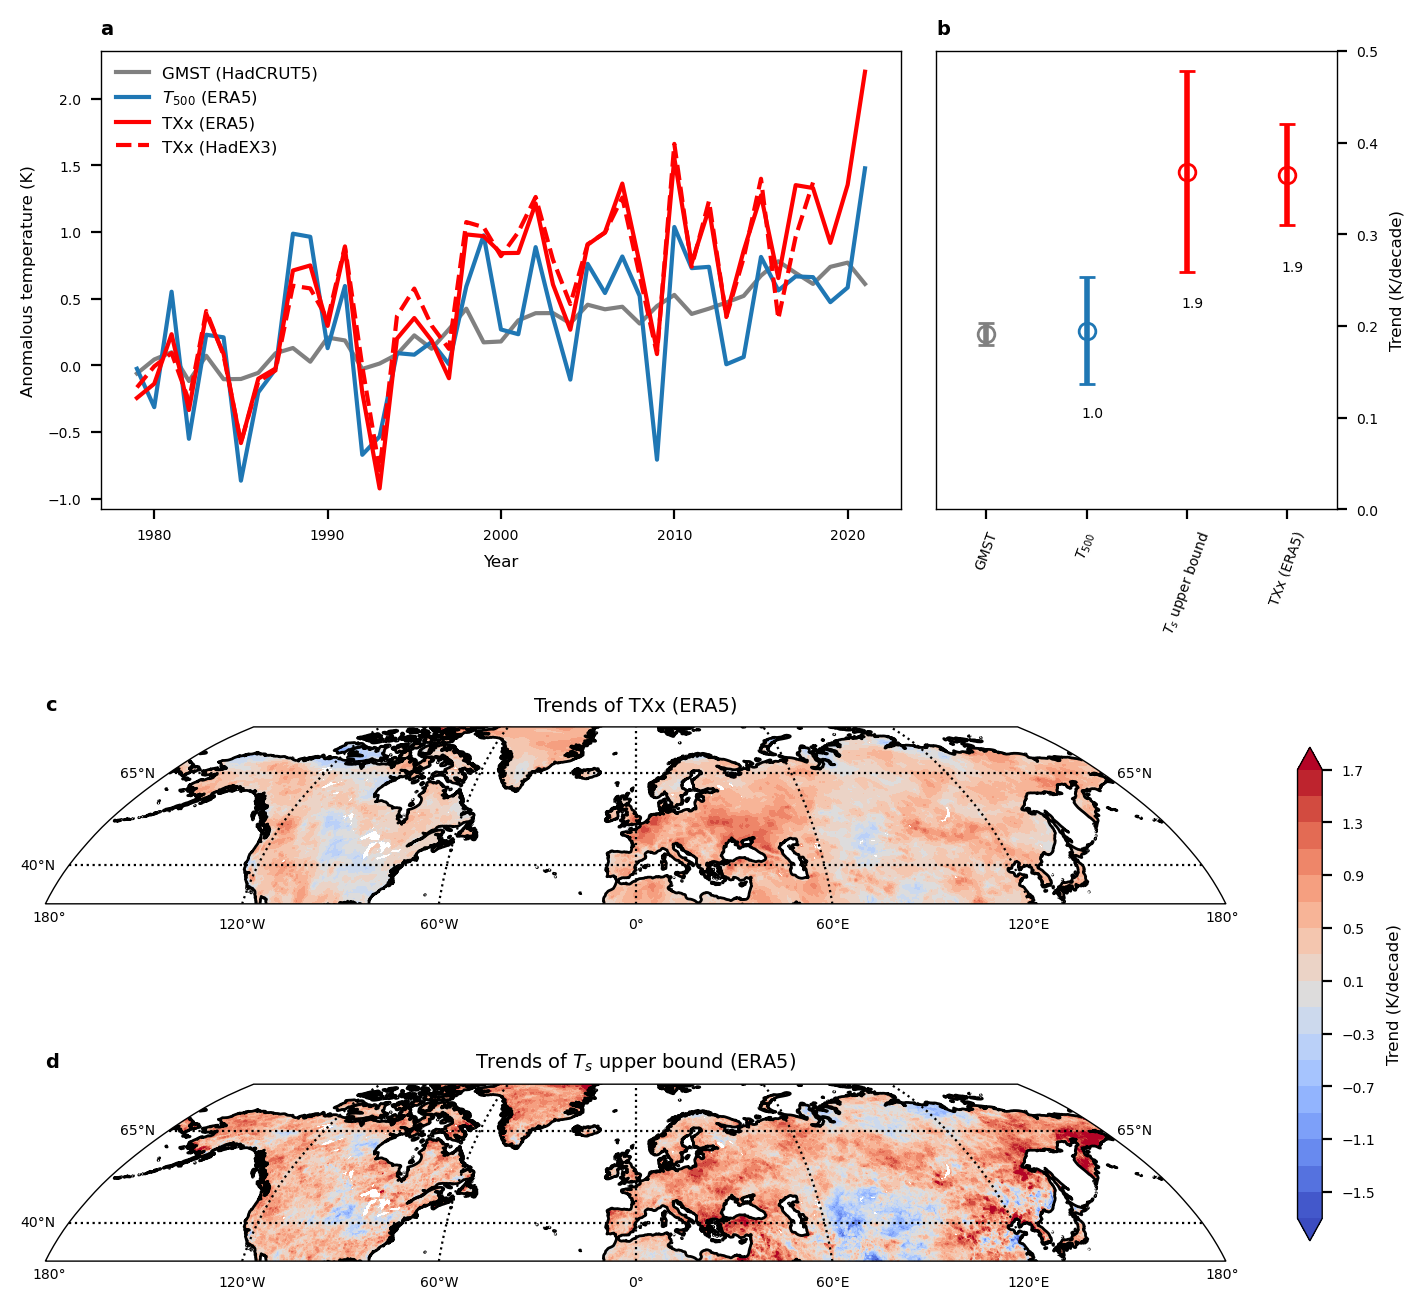

In [27]:
%%time
fig = plt.figure(constrained_layout=True,figsize=(7.,6.5))
subfigs = fig.subfigures(2,1,height_ratios=(1,1.), hspace=0.05)

subfig0 = subfigs[0].subplots(1,2, gridspec_kw = {'width_ratios': (2,1), 'wspace': 0.05})
subfig1 = subfigs[1].subplots(2,1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace':0.15})
ax0 = subfig0[0]
ax1 = subfig0[1]
ax3 = subfig1[0]
ax4 = subfig1[1]
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")


ax0.plot(np.arange(1979,2022), gmst[1979-1850:2022-1850]-gmst[1979-1850:1979-1850+10].mean(), c='grey', label='GMST (HadCRUT5)')
ax0.plot(np.arange(1979,2022), t500_of_TXx_mean-t500_of_TXx_mean[0:10].mean(), c='C0', label='$T_{\mathrm{500}}$ (ERA5)')
ax0.plot(np.arange(1979,2022), TXx_mean-TXx_mean[0:10].mean(), c='r', label='TXx (ERA5)')
ax0.plot(np.arange(1979,2019), TXx_ex-TXx_ex[0:10].mean(), c='r', ls='--', label='TXx (HadEX3)')
ax0.legend(frameon=0)
ax0.set_xlabel('Year')
ax0.set_ylabel('Anomalous temperature (K)')
ax0.set_title('a', weight='bold', loc='left')

obj = sts.linregress(np.arange(1979,2022), gmst.sel(time=slice('1979','2021')))
slope_gmst = obj.slope
std_gmst = obj.stderr
ax1.errorbar(-1, obj.slope*10, yerr=obj.stderr*10, marker='o', mfc='None', capsize=3, color='grey', lw=2)
obj = sts.linregress(np.arange(1979,2022), t500_of_TXx_mean.sel(time=slice('1979','2021')))
ax1.errorbar(0, obj.slope*10, yerr=obj.stderr*10, marker='o', mfc='None', capsize=3, color='C0', lw=2)
ax1.text(-0.05, 0.1, "{:.1f}".format(obj.slope/slope_gmst))
ax1.errorbar(1, TXx_trend_proj*10, yerr=TXx_trend_proj_std*10, marker='o', mfc='None', capsize=3, color='r', lw=2)
ax1.text(0.95, 0.22, "{:.1f}".format(TXx_trend_proj.values/slope_gmst))
obj = sts.linregress(np.arange(1979,2022), TXx_mean.sel(time=slice('1979','2021')))
ax1.errorbar(2,obj.slope*10, yerr=obj.stderr*10, marker='o', mfc='None', capsize=3, color='r', lw=2)
ax1.text(1.95, 0.26, "{:.1f}".format(obj.slope/slope_gmst))
ax1.set_xlim(-1.5,2.5)
ax1.set_xticks([-1, 0,1,2])
ax1.set_xticklabels(['GMST', '$T_{\mathrm{500}}$','$T_s$ upper bound','TXx (ERA5)'],rotation=70)
ax1.set_ylabel('Trend (K/decade)')
ax1.set_title('b', weight='bold', loc='left')
ax1.set_ylim([0, 0.5])


ax3.coastlines(color='k', linewidth=1)
ax3.set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
ax3.set_title('c', weight='bold', loc='left')
gl = ax3.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60), 
                  ylocs=np.arange(40, 70, 25), linestyle=':', 
                  color='k', alpha=1, draw_labels=True)
gl.right_labels =0
gl.top_labels=0
ax3.set_title('Trends of TXx (ERA5)')
data, lon = add_cyclic_point(reg_TXx.slope*10, coord=reg_TXx.longitude.values, axis=1)
im = ax3.contourf(lon, reg_TXx.latitude.values, data, transform=ccrs.PlateCarree(),levels=np.arange(-1.7, 1.71, 0.2), extend='both', cmap='coolwarm')


ax4.coastlines(color='k', linewidth=1)
ax4.set_extent([-180, 180, 30, 80], crs=ccrs.PlateCarree())
ax4.set_title('d', weight='bold', loc='left')
gl = ax4.gridlines(ccrs.PlateCarree(), xlocs=np.arange(-180,180.01,60), 
                  ylocs=np.arange(40, 70, 25), linestyle=':', 
                  color='k', alpha=1, draw_labels=True)
gl.right_labels =0
gl.top_labels=0
data, lon = add_cyclic_point(reg_TXx_proj.slope*10, coord=reg_TXx_proj.longitude.values, axis=1)
im = ax4.contourf(lon, reg_TXx_proj.latitude.values, data, transform=ccrs.PlateCarree(),levels=np.arange(-1.7, 1.71, 0.2), extend='both', cmap='coolwarm')



ax4.set_title('Trends of $T_s$ upper bound (ERA5)')
subfigs[1].colorbar(shrink=0.8, ax=subfig1, label='Trend (K/decade)', mappable=im)

# plt.savefig('./Fig4.pdf')
